## Libraries

In [31]:
import os
import pandas as pd
import numpy as np 
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import obspy
from obspy.signal.filter import bandpass, bandstop
from jupyterthemes import jtplot
# you can select an alternative theme's plot style by name
# oceans16 | grade3 | chesterish | onedork | monokai | solarizedl
jtplot.style('onedork')
%matplotlib notebook

## Loadind Data

In [73]:
DATADIR = "DB_NG"
DATAFILE = "Marcha - Walmário Araújo Falcão - Dia 17.04.29 as 17.07_data.txt"

datafile = os.path.join(DATADIR, DATAFILE)
df = pd.read_csv(datafile, sep=",", skiprows=1, header=None, names=['Time', 'VL', 'GM', 'SM', 
                                                                    'BF'])

df = df.dropna()

df.head()

,Time,VL,GM,SM,BF
0,0.0000,961.762312,337.546734,1205.784422,1007.657160
1,0.0005,956.146734,341.758418,1202.976633,1028.715578
2,0.0010,954.742840,344.566207,1201.572738,1044.158418
3,0.0015,963.166207,343.162312,1208.592211,1045.562312
4,0.0020,960.358418,337.546734,1205.784422,1049.773996


## Functions: RMS, FFT

In [70]:
def window_rms(data, window_size):
    data2 = np.power(data,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(data2, window, 'valid'))

def plot_fft(x, fs):
    X =np.abs(np.fft.fft(x))
    f =np.linspace(0, fs,x.shape[0])
    plt.plot(f,X, linewidth=0.2)
    plt.xlabel("Frequency")
    plt.show()

In [77]:
def filteremg(fs, init_c, final_c, dom, time, emg, low_pass=10., sfreq=2000., 
              high_band=20., low_band=450.):
    """
    time: Time data
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq)
    low_band = low_band/(sfreq)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    # apply rms function to rectified signal
    rms = window_rms(emg_envelope,200)
    
    # apply fft function to rectified signal
    X =np.abs(np.fft.fft(emg))
    f =np.linspace(0, fs,emg.shape[0])
    
    # plot graphs
    fig = plt.figure()
    plt.subplot(5, 1, 1)
    plt.subplot(5, 1, 1).set_title('Unfiltered,' + '\n' + 'unrectified EMG')
    plt.plot(time, emg, linewidth=0.2)
    p = plt.axvspan(0.0530, 0.6900, facecolor='#70659e', alpha=0.5)
    plt.annotate('C1', xy=(len(dom)*.32, dom.max() * 1.1))
    plt.xlabel('Time [sec]')
    plt.ylabel('EMG [u.v.]')
    
    plt.subplot(5, 1, 2)
    plt.subplot(5, 1, 2).set_title('Filtered,' + '\n' + 'rectified EMG: ' + str(int(high_band*sfreq)) + '-' + str(int(low_band*sfreq)) + 'Hz')
    plt.plot(time, emg_rectified, linewidth=0.2)
    p = plt.axvspan(0.0530, 0.6900, facecolor='#70659e', alpha=0.5)
    plt.annotate('C1', xy=(len(dom)*.32, dom.max() * 1.1))
    plt.xlabel('Time [sec]')
    plt.ylabel('EMG [u.v.]')

    plt.subplot(5, 1, 3)
    plt.subplot(5, 1, 3).set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(low_pass*sfreq)) + ' Hz')
    plt.plot(time, emg_envelope)
    p = plt.axvspan(0.0530, 0.6900, facecolor='#70659e', alpha=0.5)
    plt.annotate('C1', xy=(len(dom)*.32, dom.max() * 1.1))
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=4)
    plt.xlim(0.0, 0.8)
    plt.ylim(0, 3800)
    plt.plot([0.9, 1.0], [1.0, 1.0], 'r-', lw=5)
    plt.xlabel('Time [sec]')
    plt.ylabel('EMG [u.v.]')
    
    plt.subplot(5, 1, 4)
    plt.subplot(5, 1, 4).set_title('Filtered, rectified ' + '\n' + 'EMG RMS envelope: ' + str(int(low_pass*sfreq)) + ' Hz')
    plt.plot(rms)
    p = plt.axvspan(0.0530, 0.6900, facecolor='#70659e', alpha=0.5)
    plt.annotate('C1', xy=(len(dom)*.32, dom.max() * 1.1))
    plt.xlabel('Time [sec]')
    plt.ylabel('EMG [u.v.]')

    plt.subplot(5, 1, 5)
    plt.subplot(5, 1, 5).set_title('Unfiltered,' + '\n' + 'unrectified FFT EMG')
    plt.plot(f,X, linewidth=0.2)
    plt.annotate('C1', xy=(len(dom)*.32, dom.max() * 1.1))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('EMG [u.v.]')
    
    fig_name = 'fig_' + str(int(low_pass*sfreq)) + '.png'
    fig.set_size_inches(w=11,h=7)
    fig.savefig(fig_name)



<IPython.core.display.Javascript object>


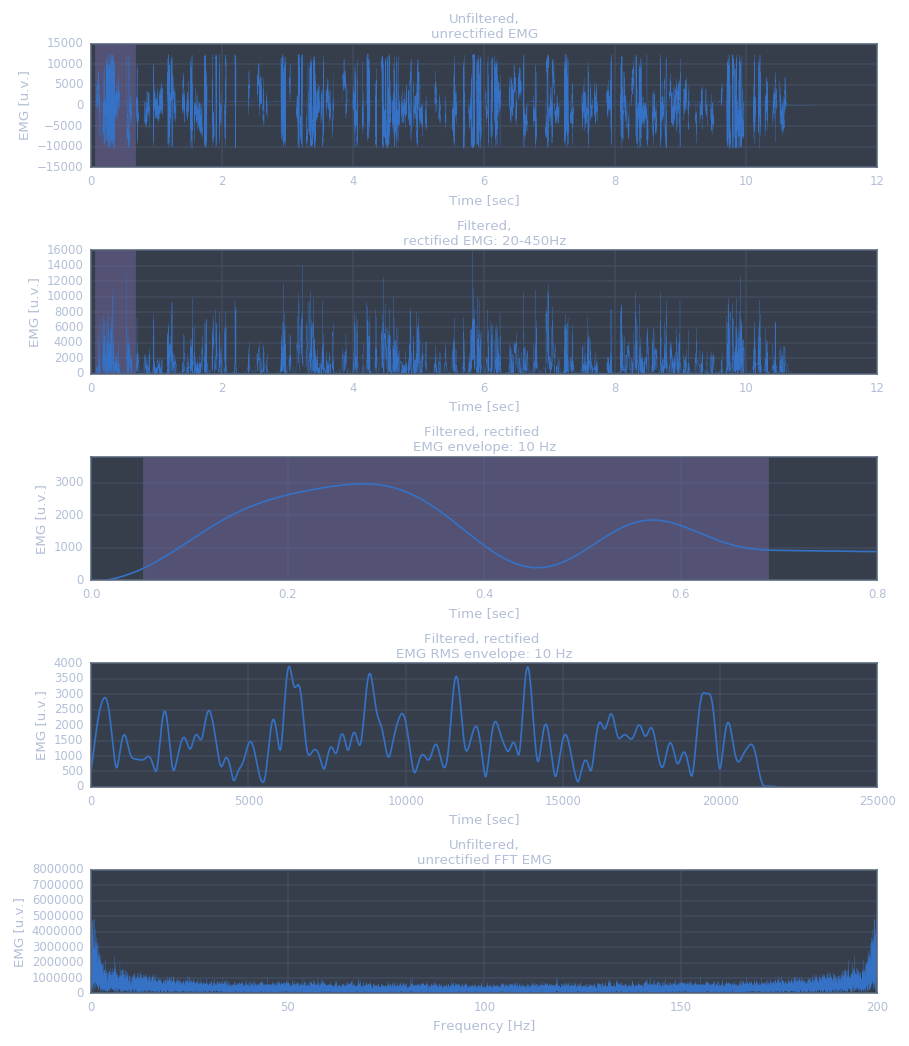

In [78]:
init_c = 106
final_c = 1380
dom = df['BF'][106:1380]
fs = 200

filteremg(fs, init_c, final_c, dom, df['Time'], df['BF'], low_pass=10)

In [51]:
rms = window_rms(df['BF'], 200)

In [52]:
len(rms)

21801

In [53]:
len(df['Time'])

22000